## Orbital history of Crater II
Using the mass loss calibration with proper motion for the s=1 sims

In [1]:
import sys
import aa_py
%matplotlib inline
%load_ext autoreload
%autoreload 2
from orbit import *

First, we compute how much the velocity dispersion is suppressed relative to a `universal' halo.

In [2]:
vmax_sawala,sig_vmax_sawala=17.6,3.2
c=20.
Delta=101.1
crater2_veldisp = 2.6

low_sig0 = crater2_veldisp/(nbody_tools.Vc_NFW(1.1*(4./3.),
                                   nbody_tools.rs_Vmax(vmax_sawala-sig_vmax_sawala,c,Delta=Delta),
                                   c=c,Delta=Delta)/np.sqrt(2.5))
med_sig0 = crater2_veldisp/(nbody_tools.Vc_NFW(1.1*(4./3.),
                                   nbody_tools.rs_Vmax(vmax_sawala,c,Delta=Delta),
                                   c=c,Delta=Delta)/np.sqrt(2.5))
hi_sig0 =  crater2_veldisp/(nbody_tools.Vc_NFW(1.1*(4./3.),
                                   nbody_tools.rs_Vmax(vmax_sawala+sig_vmax_sawala,c,Delta=Delta),
                                   c=c,Delta=Delta)/np.sqrt(2.5))
print low_sig0, med_sig0, hi_sig0

0.2904032748730794 0.24242693622511258 0.20982927033336046


## Orbit samples
We generate samples for the unknown proper motion (using a Gaussian in transverse velocity with width $100\,\mathrm{km\,s}^{-1}$ and trace back the orbital history. We use the Hayashi relations to find the mass within the initial projected half-light radius (using a segregation parameter of $2$).

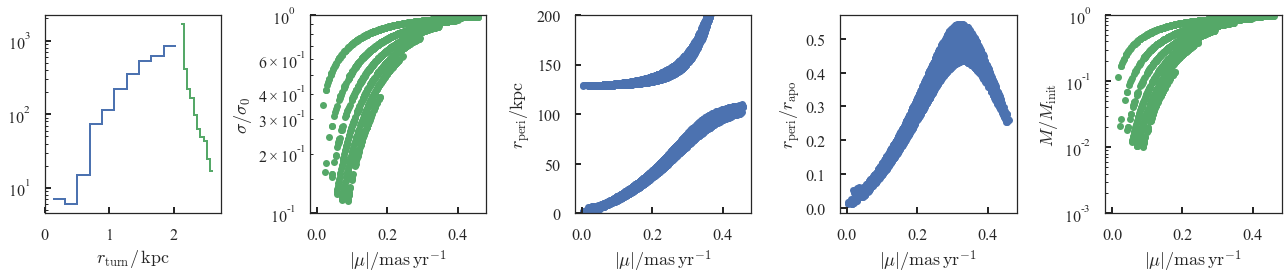

In [3]:
f,a=plt.subplots(1,5,figsize=(18,4))
plt.subplots_adjust(wspace=0.4)
rperi,rapo,pmmag_list,ang_list=[],[],[],[]
unbound=[]
nperi=[]
massloss=[]
massloss_h=[]
times_ok=[]

eq = crater2_eq()
solar_reflex = crater2_solarreflex()

SegregationParameter = 2.

veldisp=140.
samples = np.random.multivariate_normal(mean=solar_reflex,cov=np.diag(np.ones(2))*(veldisp/4.74/distance)**2,
                                        size=5000)

pmra_list,pmdec_list = [], []

rs_nfw=1.45
c = 20.
Delta = 101.1

def mass_loss_formula(mu_abs, scl=0.14):
    return 1.-np.exp(-mu_abs/scl)

times = np.random.uniform(size=len(samples))*13.7

for s,t in zip(samples,times):
    Eq = np.array([eq[0],eq[1],distance,vlos,
                    s[0],s[1]])
    R,T = integrate_orbits_backwards(Eq, total_time=t)
    if len(R)==0:
        unbound.append(True)
        continue
    else:
        unbound.append(False)
    if count_pericentres(R)==0:
        continue
    times_ok.append(T[-1])
    rperi.append(pericentre(R))
    rapo.append(apocentre(R))
    pmra_list.append(s[0])
    pmdec_list.append(s[1])
    pmmag = np.sqrt((s[0]-solar_reflex[0])**2+(s[1]-solar_reflex[1])**2)
    nperi.append(count_pericentres(R))
    massloss_h.append(np.power(mass_loss_formula(pmmag),nperi[-1]))
    if(massloss_h[-1]<1e-2):
        massloss_h[-1]=0.
#     massloss.append(mass_loss(rperi[-1],rapo[-1],nperi[-1],rs_nfw,c=c,Delta=Delta))
#     massloss_h.append(mass_loss_hayashi(rperi[-1],rapo[-1],nperi[-1],rs_nfw,c=c,
#                                       Delta=Delta,rlim=0.03*rs_nfw,rtotal=rs_nfw/SegregationParameter))
    pmmag_list.append(pmmag)
    
    a[1].plot([pmmag],penarrubia_tracks_Mh(massloss_h[-1])[0],'.',color=sns.color_palette()[1])
    a[2].plot([pmmag],[np.min(np.sqrt(R.T[0]**2+R.T[1]**2+R.T[2]**2))],'.',color=sns.color_palette()[0])
    a[2].plot([pmmag],[np.max(np.sqrt(R.T[0]**2+R.T[1]**2+R.T[2]**2))],'.',color=sns.color_palette()[0])

#     a[4].plot([pmmag],[massloss[-1]],'.',color=sns.color_palette()[0])
    a[4].plot([pmmag],[massloss_h[-1]],'.',color=sns.color_palette()[1])
plt.sca(a[0])
plt.hist(np.log10(rperi),histtype='step',lw=2);
plt.hist(np.log10(rapo),histtype='step',lw=2);
plt.xlabel(r'$r_\mathrm{turn}/\,\mathrm{kpc}$')
plt.semilogy()
a[1].set_ylabel(r'$\sigma/\sigma_0$')
a[1].set_xlabel(r'$|\mu|/\mathrm{mas\,yr}^{-1}$')
plt.sca(a[1]);plt.semilogy();plt.ylim(1e-1,1.)
a[2].set_ylabel(r'$r_\mathrm{peri}/\mathrm{kpc}$')
a[2].set_xlabel(r'$|\mu|/\mathrm{mas\,yr}^{-1}$')
plt.sca(a[2]);plt.ylim(0.,200.)
plt.sca(a[3]);
plt.plot(np.array(pmmag_list),np.array(rperi)/np.array(rapo),'.')
# plt.xlim(0.,0.35)
a[3].set_xlabel(r'$|\mu|/\mathrm{mas\,yr}^{-1}$')
a[3].set_ylabel(r'$r_\mathrm{peri}/r_\mathrm{apo}$')
a[4].set_ylabel(r'$M/M_\mathrm{init}$')
a[4].set_xlabel(r'$|\mu|/\mathrm{mas\,yr}^{-1}$')
plt.sca(a[4]);plt.semilogy();plt.ylim(1e-3,1.)
plt.tight_layout()

In [4]:
massloss=massloss_h
fltr = np.array(massloss)>0.
massloss=np.array(massloss)[fltr]
pmra_list=np.array(pmra_list)[fltr]
pmdec_list=np.array(pmdec_list)[fltr]
pmmag_list = np.array(pmmag_list)[fltr]

In [5]:
times_ok =np.array(times_ok)[fltr]

## Plot the properties

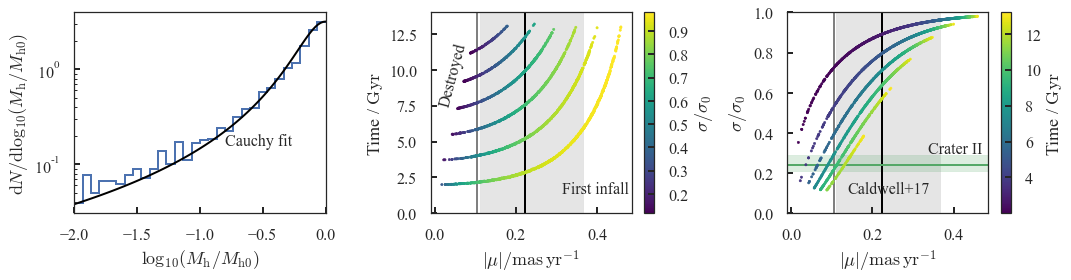

In [10]:
f,a=plt.subplots(1,3,figsize=[15.,4.])

plt.sca(a[0])
xmax = -2.
n,b,p=plt.hist(np.log10(massloss),histtype='step',bins=30,normed=True,lw=2, range=[xmax,0.]);
xx = np.linspace(xmax,0.,100)
from scipy.stats import cauchy
cauchy_width=0.22
plt.plot(xx,cauchy.pdf(xx/cauchy_width)/cauchy.pdf((b[-2]+b[-1])*0.5/cauchy_width)*n[-1],color='k')
plt.semilogy()
plt.xlim(xmax,0.)
plt.annotate('Cauchy fit',xy=(0.6,0.34),rotation=0.,xycoords='axes fraction',fontsize=16)
plt.xlabel(r'$\log_{10}(M_\mathrm{h}/M_\mathrm{h0})$')
plt.ylabel(r'$\mathrm{d}N/\mathrm{d}\log_{10}(M_\mathrm{h}/M_\mathrm{h0})$')

plt.sca(a[2])
plt.scatter(pmmag_list,penarrubia_tracks_Mh(massloss)[0],c=np.array(times_ok),
            s=5,cmap=plt.cm.viridis,zorder=10)
plt.ylabel(r'$\sigma/\sigma_0$')
plt.colorbar(label=r'Time / $\mathrm{Gyr}$')
plt.ylim(0.,1.)
plt.xlabel(r'$|\mu|/\mathrm{mas\,yr}^{-1}$')
# plt.scatter(pmmag_list,np.array(nperi)[fltr],c=np.array(times_ok)[fltr],
#             s=2,cmap=plt.cm.viridis)
plt.sca(a[1])
plt.scatter(pmmag_list,np.array(times_ok),c=penarrubia_tracks_Mh(massloss)[0],
            s=5,cmap=plt.cm.viridis,zorder=10)
# plt.ylim(1e-2,)
plt.ylim(0.,14.)
plt.ylabel(r'Time / $\mathrm{Gyr}$')
plt.colorbar(label=r'$\sigma/\sigma_0$')
plt.xlabel(r'$|\mu|/\mathrm{mas\,yr}^{-1}$')
plt.annotate('First infall',xy=(0.65,0.1),xycoords='axes fraction',fontsize=16)
plt.annotate('Destroyed',xy=(0.03,0.8),rotation=75.,xycoords='axes fraction',fontsize=16)
plt.tight_layout()

pmm_point = np.sqrt((-0.18-solar_reflex[0])**2+(-0.14-solar_reflex[1])**2)

mm = np.random.multivariate_normal(mean=[-0.18,-0.14],cov=np.diag([0.16,0.19])**2,size=1000)

err=np.percentile(np.sqrt((mm.T[0]-solar_reflex[0])**2+(mm.T[1]-solar_reflex[1])**2),[15.,85.])
pmm = np.median(np.sqrt((mm.T[0]-solar_reflex[0])**2+(mm.T[1]-solar_reflex[1])**2))
plt.axvline(pmm,color='k')
plt.axvline(pmm_point,color='gray')
plt.axvspan(*err,color='gray',alpha=0.2)
plt.sca(a[2])
plt.axvline(pmm,color='k')
plt.axvline(pmm_point,color='gray')
plt.axvspan(*err,color='gray',alpha=0.2)
plt.axhspan(low_sig0,hi_sig0,color=sns.color_palette()[1],alpha=0.2)
plt.axhline(med_sig0,color=sns.color_palette()[1])
plt.annotate('Crater II',xy=(0.7,0.3),rotation=0.,xycoords='axes fraction',fontsize=16)
plt.annotate('Caldwell+17',xy=(0.3,0.1),rotation=0.,xycoords='axes fraction',fontsize=16)
# plt.savefig('orbit_history.png',bbox_inches='tight')

/data/jls/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


(0.0, 0.6)

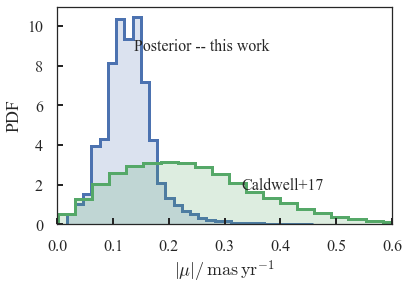

In [11]:
g = np.genfromtxt('014_mass_samples.dat')
from scipy.stats import kde
KDE = kde.gaussian_kde(g)
plt.hist(pmmag_list,weights=KDE(np.log10(massloss))/cauchy.pdf(np.log10(massloss)/cauchy_width),
         normed=True,lw=3,histtype='step',bins=30,label=None)
plt.hist(pmmag_list,weights=KDE(np.log10(massloss))/cauchy.pdf(np.log10(massloss)/cauchy_width),
         normed=True,lw=3,bins=30,edgecolor='None',alpha=0.2,color=sns.color_palette()[0])
mm = np.random.multivariate_normal(mean=[-0.18,-0.14],cov=np.diag([0.16,0.19])**2,size=10000)
plt.hist(np.sqrt((mm.T[0]-solar_reflex[0])**2+(mm.T[1]-solar_reflex[1])**2),lw=3,normed=True,
         histtype='step',bins=30,label=None);
plt.hist(np.sqrt((mm.T[0]-solar_reflex[0])**2+(mm.T[1]-solar_reflex[1])**2),lw=3,normed=True,bins=30,
         edgecolor='None',color=sns.color_palette()[1],alpha=0.2);
plt.annotate('Caldwell+17',xy=(0.55,0.16),rotation=0.,xycoords='axes fraction',fontsize=16)
plt.annotate('Posterior -- this work',xy=(0.23,0.8),rotation=0.,xycoords='axes fraction',fontsize=16)
plt.ylabel('PDF')
plt.xlabel(r'$|\mu|/\,\mathrm{mas\,yr}^{-1}$')
plt.legend()
plt.xlim(0.,0.6)
# plt.savefig('abs_mu_pdf.pdf',bbox_inches='tight')

In [12]:
theta = np.linspace(0.,2*np.pi,len(pmmag_list))
pmx = pmmag_list*np.cos(theta)
pmy = pmmag_list*np.sin(theta)
weights=KDE(np.log10(massloss))/cauchy.pdf(np.log10(massloss)/cauchy_width)
meanx = np.sum((pmx+solar_reflex[0])*weights)/np.sum(weights)
print meanx
print np.sqrt(np.sum((pmx+solar_reflex[0]-meanx)**2*weights)/np.sum(weights))
meany = np.sum((pmy+solar_reflex[1])*weights)/np.sum(weights)
print meany
print np.sqrt(np.sum((pmy+solar_reflex[1]-meany)**2*weights)/np.sum(weights))
print solar_reflex[0],solar_reflex[1]

-0.2052069664219933
0.09758801277100869
-0.2387860298615204
0.09773467532641947
-0.20604149358202092 -0.24069634429010772


9.255283795037508 3.5440749253023327 2.4555823082341206


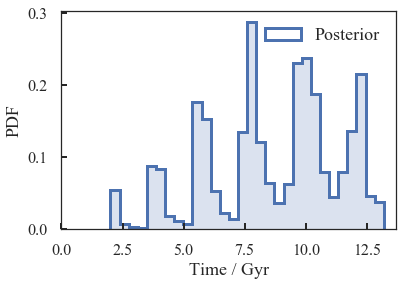

In [13]:
g = np.genfromtxt('014_mass_samples.dat')
from scipy.stats import kde
KDE = kde.gaussian_kde(g)
plt.hist(times_ok,weights=weights,
         normed=True,lw=3,histtype='step',bins=30,label='Posterior')
plt.hist(times_ok,weights=weights,
         normed=True,lw=3,bins=30,edgecolor='None',alpha=0.2,color=sns.color_palette()[0])
plt.ylabel(r'PDF')
plt.xlabel(r'Time / Gyr')
plt.legend()
plt.xlim(0.,13.7)
plt.savefig('time_pdf.pdf',bbox_inches='tight')

def weighted_quantile(values, quantiles, sample_weight=None, values_sorted=False, old_style=False):
    """ Very close to np.percentile, but supports weights.
    NOTE: quantiles should be in [0, 1]!
    :param values: np.array with data
    :param quantiles: array-like with many quantiles needed
    :param sample_weight: array-like of the same length as `array`
    :param values_sorted: bool, if True, then will avoid sorting of initial array
    :param old_style: if True, will correct output to be consistent with np.percentile.
    :return: np.array with computed quantiles.
    """
    values = np.array(values)
    quantiles = np.array(quantiles)
    if sample_weight is None:
        sample_weight = np.ones(len(values))
    sample_weight = np.array(sample_weight)
    assert np.all(quantiles >= 0) and np.all(quantiles <= 1), 'quantiles should be in [0, 1]'

    if not values_sorted:
        sorter = np.argsort(values)
        values = values[sorter]
        sample_weight = sample_weight[sorter]

    weighted_quantiles = np.cumsum(sample_weight) - 0.5 * sample_weight
    if old_style:
        # To be convenient with np.percentile
        weighted_quantiles -= weighted_quantiles[0]
        weighted_quantiles /= weighted_quantiles[-1]
    else:
        weighted_quantiles /= np.sum(sample_weight)
    return np.interp(quantiles, weighted_quantiles, values)

XX = weighted_quantile(times_ok,[0.16,0.5,0.84],sample_weight=weights)
print XX[1], XX[1]-XX[0], XX[2]-XX[1]

## Mass to light ratio
Fitting functions from CraterII_sim_S1_PM10

1.3007594057312892 0.3418824924423989 0.3194089970913121


(array([  136.,   766.,  3741.,  6637., 11608., 14236., 13720., 11065.,
         7539.,  5552.]),
 array([0.30867635, 0.47316373, 0.63765111, 0.80213849, 0.96662587,
        1.13111325, 1.29560063, 1.46008801, 1.62457539, 1.78906277,
        1.95355015]),
 <a list of 1 Patch objects>)

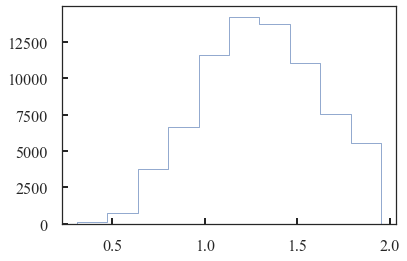

In [14]:
def pen_functions(xx,alpha,beta):
    return 2.**alpha*xx**beta/(1.+xx)**alpha
perc = np.percentile(np.log10(90./pen_functions(np.power(10.,g),-2.,-1.2)),[16.,50.,84.])
print perc[1],perc[2]-perc[1],perc[1]-perc[0]
plt.hist(np.log10(90./pen_functions(np.power(10.,g),-2.,-1.2)),histtype='step')

## Initial luminosity
Fitting functions from CraterII_sim_S1_PM10

7.059803554445001 0.6427663576975409 0.7698868380108115


(array([ 2058.,  4035.,  6630., 10811., 14796., 16163., 11946.,  6387.,
         1996.,   178.]),
 array([5.18192216, 5.56172462, 5.94152708, 6.32132954, 6.70113199,
        7.08093445, 7.46073691, 7.84053937, 8.22034183, 8.60014428,
        8.97994674]),
 <a list of 1 Patch objects>)

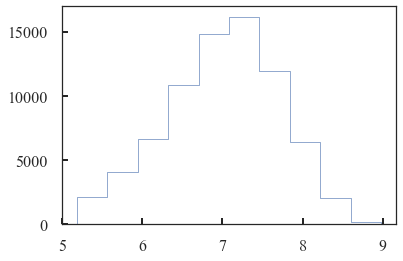

In [15]:
perc = np.percentile(np.log10(1.5e5/pen_functions(np.power(10.,g),1.,2.2)),[16.,50.,84.])
print perc[1],perc[2]-perc[1],perc[1]-perc[0]
plt.hist(np.log10(1.5e5/pen_functions(np.power(10.,g),1.,2.2)),histtype='step')

### Appendix

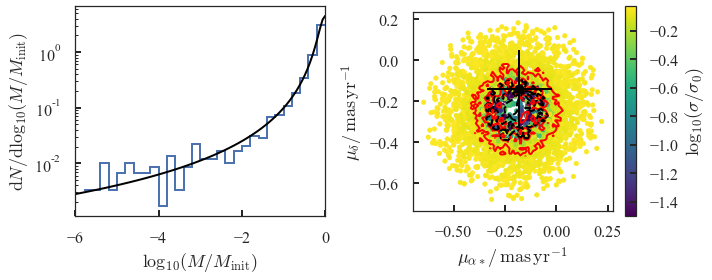

In [410]:
f,a=plt.subplots(1,2,figsize=[10.,4.]);
plt.sca(a[0])
xmax = -6.
n,b,p=plt.hist(np.log10(massloss),histtype='step',bins=30,normed=True,lw=2, range=[xmax,0.]);
from scipy.stats import gaussian_kde
GKDE = gaussian_kde(np.append(np.log10(massloss),-np.log10(massloss)))
xx = np.linspace(xmax,0.,100)
from scipy.stats import cauchy
plt.plot(xx,cauchy.pdf(xx/0.15)/cauchy.pdf((b[-2]+b[-1])*0.5/0.15)*n[-1],color='k')
plt.semilogy()
plt.xlim(xmax,0.)
# plt.ylim(0.,2.)
import cPickle as pickle
with open('gkde_massloss.pkl','w') as f:
    pickle.dump(GKDE,f)
plt.xlabel(r'$\log_{10}(M/M_\mathrm{init})$')
plt.ylabel(r'$\mathrm{d}N/\mathrm{d}\log_{10}(M/M_\mathrm{init})$')

from scipy.interpolate import griddata as gd
f = gd(np.vstack((pmra_list,pmdec_list)).T, np.log10(massloss), 
             ([-0.18],[-0.14]), method='linear')

plt.axvline(f,color='k',ls='dashed')

plt.sca(a[1])
plt.scatter(pmra_list,pmdec_list,
            c=np.log10(penarrubia_tracks_Mh(np.array(massloss))[0]),
            cmap=plt.cm.viridis,s=20,vmin=-1.5)
plt.colorbar(label=r'$\log_{10}(\sigma/\sigma_0)$')
plt.xlabel(r'$\mu_{\alpha*}/\,\mathrm{mas\,yr}^{-1}$')
plt.ylabel(r'$\mu_\delta/\,\mathrm{mas\,yr}^{-1}$')
# plt.plot(solar_reflex[:1],solar_reflex[-1:],'^',color='r',ms=10)
plt.gca().set_aspect('equal')
from matplotlib.mlab import griddata
# define grid.
xi = np.linspace(solar_reflex[0]-0.3, solar_reflex[0]+0.3, 50)
yi = np.linspace(solar_reflex[1]-0.3, solar_reflex[1]+0.3, 50)
# grid the data.
zi = griddata(pmra_list,pmdec_list,
              np.log10(penarrubia_tracks_Mh(np.array(massloss))[0]), xi, yi, interp='linear')
# contour the gridded data, plotting dots at the nonuniform data points.
CS = plt.contour(xi, yi, np.abs(zi), [-np.log10(0.8)], linewidths=2, colors='r')
CS = plt.contour(xi, yi, np.abs(zi), [-np.log10(0.4)], linewidths=2, colors='r')
CS = plt.contour(xi, yi, np.abs(zi), [-np.log10(0.2)], linewidths=2, colors='k',linestyles='dashed')
CS = plt.contour(xi, yi, np.abs(zi), [-np.log10(0.001)], linewidths=2, colors='r')
# CS = plt.contour(xi, yi, np.abs(zi), [-np.log10(0.4)], linewidths=2, colors='k')

plt.errorbar([-0.18],[-0.14],xerr=[0.16],yerr=[0.19],color='k',fmt='o',ms=10)
# plt.errorbar([])
# plt.plot([0.],[0.],'^',markerfacecolor='None',markeredgecolor='r',ms=10,markeredgewidth=1.)
# plt.plot([0.],[0.17],'^',markerfacecolor='None',markeredgecolor='r',ms=10,markeredgewidth=1.)

plt.tight_layout()
# plt.savefig('orbit.png',bbox_inches='tight')

In [374]:
Eq = np.array([eq[0],eq[1],distance,vlos,
                    solar_reflex[0]+0.45,solar_reflex[1]])
R,T = integrate_orbits_backwards(Eq, total_time=14.)

1


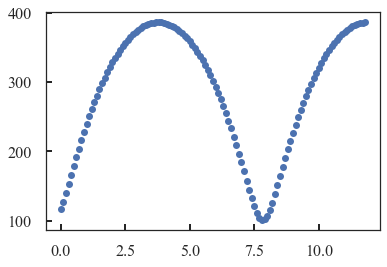

In [375]:
plt.plot(T,np.sqrt(R.T[0]**2+R.T[1]**2+R.T[2]**2),'.')
print count_pericentres(R)
# plt.plot(T,R.T[5],'.')
# plt.ylim(0.,200.)

In [366]:
np.max(np.sqrt(samples.T[0]**2+samples.T[1]**2))

0.6106920005373393

In [89]:
penarrubia_tracks_Mh(0.05)[0]

0.23953818120523773

In [91]:
penarrubia_tracks_Mh(0.05)[1]

0.7245855431402495

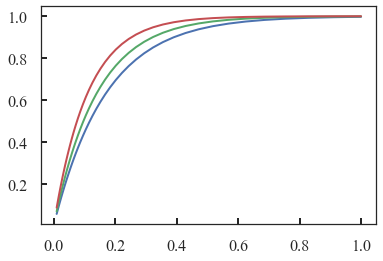

In [12]:
xx = np.logspace(-2.,0.)
plt.plot(xx,1.-np.exp(-xx/0.17))
plt.plot(xx,1.-np.exp(-xx/0.14))
plt.plot(xx,1.-np.exp(-xx/0.11))